In [1]:
# Source: https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/

# Environment

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# check pytorch version
import torch
print(torch.__version__)

2.0.1+cu118


In [4]:
def cpu():  #@save
    """Get the CPU device."""
    return torch.device('cpu')

def gpu(i=0):  #@save
    """Get a GPU device."""
    return torch.device(f'cuda:{i}')

cpu(), gpu(), gpu(1)

(device(type='cpu'),
 device(type='cuda', index=0),
 device(type='cuda', index=1))

In [5]:
# https://colab.research.google.com/github/d2l-ai/d2l-pytorch-colab/blob/master/chapter_builders-guide/use-gpu.ipynb#scrollTo=0725f553
torch.device('cuda')
# torch.device('cpu')

device(type='cuda')

# Dataset formation

In [6]:
import json

dataset_path = "/content/drive/MyDrive/dataset-curr-next2.json"
# dataset_path = "/content/drive/MyDrive/dataset-curr-next.json"
# dataset_path = "/content/drive/MyDrive/UniversityStudies/stanford/cs221/project/dataset-curr-next.json"
# dataset_path = "/content/drive/MyDrive/UniversityStudies/stanford/cs221/project/dataset2.json"

f = open(dataset_path)
read_data = json.load(f)


In [7]:
{ example['reward'] for example in read_data }

{-1.0, 0.0, 0.1, 1.0}

In [8]:
read_data[0]

{'gameState': {'height': 11,
  'width': 11,
  'food': [[7, 1], [5, 6], [10, 6]],
  'hazards': [],
  'players': [{'health': 100,
    'body': [[3, 8]],
    'head': [3, 8],
    'length': 1,
    'id': 1,
    'alive': True,
    'ours': True},
   {'health': 100,
    'body': [[10, 6]],
    'head': [10, 6],
    'length': 1,
    'id': 2,
    'alive': True,
    'ours': False},
   {'health': 100,
    'body': [[6, 5]],
    'head': [6, 5],
    'length': 1,
    'id': 3,
    'alive': True,
    'ours': False}],
  'endState': False,
  'won': False,
  'lost': False,
  'tie': False},
 'action': 'left',
 'reward': 0.0,
 'nextState': {'height': 11,
  'width': 11,
  'food': [[7, 1], [5, 6], [10, 6]],
  'hazards': [],
  'players': [{'health': 99,
    'body': [[2, 8], [3, 8]],
    'head': [2, 8],
    'length': 2,
    'id': 1,
    'alive': True,
    'ours': True},
   {'health': 99,
    'body': [[9, 6], [10, 6]],
    'head': [9, 6],
    'length': 2,
    'id': 2,
    'alive': True,
    'ours': False},
   {'healt

In [9]:
# read_data = read_data[0:10]

In [10]:
read_data[0].keys()

dict_keys(['gameState', 'action', 'reward', 'nextState'])

In [11]:
rewards = { example['reward'] for example in read_data }

rewards

{-1.0, 0.0, 0.1, 1.0}

In [12]:
import numpy as np
from numpy import linalg as LA
import uuid

class GameBoard():

  def __init__(self, example, state):
    ### general
    self.id = uuid.uuid4()
    # channel
    self.channel_names = ['self_head', 'self_body', 'self_health', 'self_length',
                          'adversary_head', 'adversary_body', 'adversary_health', 'adversary_length',
                          'food', 'hazards', 
                          'left', 'right', 'down', 'up', 
                          "None"]
    # size
    cnn_size = 32
    if state['height'] > cnn_size or state['height'] > cnn_size:
      raise NotImplementedError("CNN only supports 32x32 grid")
    self.rows = cnn_size 
    self.cols = cnn_size                           
    ### specific
    self.example = example
    self.state = state
    self.set_board()
    self.set_food()
    self.set_hazard()
    self.set_player()
    self.set_action()

  def get_id(self):
    return self.id

  def channel_list(self):
    return self.channel_names

  def channel_count(self):
    return len(self.channel_names)

  def channel_idx(self, name):
    if name is None:
      name = "None"
    return self.channel_names.index(name)

  def set_board(self):
    board = []
    for i in range(self.channel_count()):
      board.append(self.new_channel())
    self.board = board

  def get_board(self):
    return self.board

  def get_reward(self):
    try:
      return self.example['reward']
    except:
      pass
    return 0

  def new_channel(self):
    channel = np.zeros((self.rows, self.cols))
    return channel

  def get_channel(self, name):
    return self.board[self.channel_idx(name)]

  def set_channel(self, name, channel):
    self.board[self.channel_idx(name)] = channel

  def mark_channel(self, name, locations, value=1):
    channel = self.get_channel(name)
    if isinstance(locations, list):
      for loc in locations:
        x, y = loc
        curr = channel[x][y]
        channel[x][y] = max([value, curr])
    else:
      for y, x in np.ndindex(channel.shape):
        curr = channel[x][y]
        channel[x][y] = max([value, curr])
    self.set_channel(name, channel)
    
  def set_food(self, name='food'):
    self.mark_channel(name, self.state[name])

  def set_hazard(self, name='hazards'):
    self.mark_channel(name, self.state[name])

  def set_action(self, name='action'):
    actual = self.example[name]
    self.mark_channel(actual, actual)

  def set_player(self):
    # {'health': 100,
    # 'body': [[6, 8]],
    # 'head': [6, 8],
    # 'length': 1,
    # 'id': 1,
    # 'alive': True,
    # 'ours': True}
    for player in self.state['players']:
      health = player['health']
      body = player['body']
      head = [player['head']]
      length = player['length']
      if player['alive']:
        if player['ours']:
          self.mark_channel('self_health', health, health)
          self.mark_channel('self_body', body)
          self.mark_channel('self_head', head)
          self.mark_channel('self_length', length)
        else:
          self.mark_channel('adversary_health', health, health)
          self.mark_channel('adversary_body', body)
          self.mark_channel('adversary_head', head)
          self.mark_channel('adversary_length', length)


class ShapedExample():
  
  def __init__(self, example):
    self.example = example
    self.board_curr = GameBoard(example, example['gameState'])
    self.board_next = GameBoard(example, example['nextState']) 
    self.board_alts = []
    for action in ['left', 'right', 'up', 'down']:
      alt = self.example.copy()
      alt['action'] = action
      board = GameBoard(alt, example['nextState'])
      self.board_alts.append(board)

In [13]:
ex = ShapedExample(read_data[0])

for ch in ex.board_curr.channel_list():
  try:
    grid = ex.board_curr.get_channel(ch)
    print(ex.example)
    print(ch, grid)
  except Exception as e:
    print(e)

{'gameState': {'height': 11, 'width': 11, 'food': [[7, 1], [5, 6], [10, 6]], 'hazards': [], 'players': [{'health': 100, 'body': [[3, 8]], 'head': [3, 8], 'length': 1, 'id': 1, 'alive': True, 'ours': True}, {'health': 100, 'body': [[10, 6]], 'head': [10, 6], 'length': 1, 'id': 2, 'alive': True, 'ours': False}, {'health': 100, 'body': [[6, 5]], 'head': [6, 5], 'length': 1, 'id': 3, 'alive': True, 'ours': False}], 'endState': False, 'won': False, 'lost': False, 'tie': False}, 'action': 'left', 'reward': 0.0, 'nextState': {'height': 11, 'width': 11, 'food': [[7, 1], [5, 6], [10, 6]], 'hazards': [], 'players': [{'health': 99, 'body': [[2, 8], [3, 8]], 'head': [2, 8], 'length': 2, 'id': 1, 'alive': True, 'ours': True}, {'health': 99, 'body': [[9, 6], [10, 6]], 'head': [9, 6], 'length': 2, 'id': 2, 'alive': True, 'ours': False}, {'health': 99, 'body': [[5, 5], [6, 5]], 'head': [5, 5], 'length': 2, 'id': 3, 'alive': True, 'ours': False}], 'endState': False, 'won': False, 'lost': False, 'tie': 

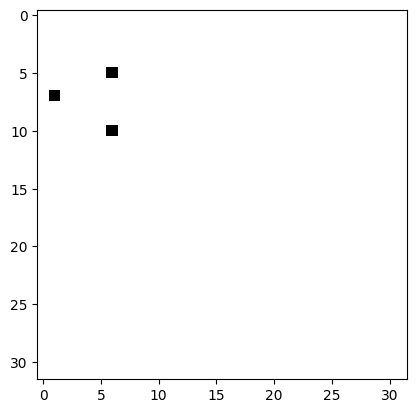

In [14]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(ex.board_curr.get_channel('food'), cmap='Greys', interpolation='none')

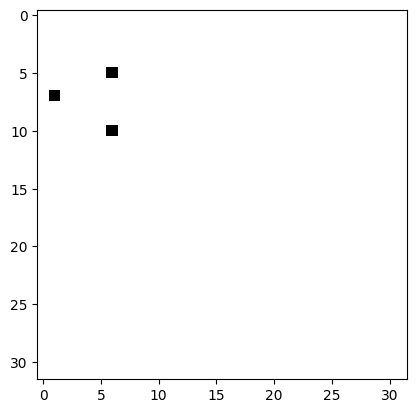

In [15]:
plt.imshow(ex.board_next.get_channel('food'), cmap='Greys', interpolation='none')

In [16]:
from torch.utils.data import Dataset

# dataset definition
class SnakeDataset(Dataset):
    # load the dataset
    def __init__(self, dataset):
        # store the inputs and outputs
        self.X = []
        self.y = []
        # self.next_reward_boards = {}
        for example in dataset:
          shaped = ShapedExample(example)
          ### X
          board_curr = shaped.board_curr.get_board()
          boards_next = [alt.get_board() for alt in shaped.board_alts]
          board_combo = np.array(boards_next)
          self.X.append(board_combo)
          ### y
          instant_reward_board =  shaped.board_curr
          self.y.append(instant_reward_board.get_reward())
        ### convert for Torch
        # device=try_gpu()
        self.X = torch.Tensor(np.array(self.X)).type(torch.FloatTensor) 
        self.y = self.regression_label() 
        # self.y = self.classification_label()

    def regression_label(self):
      return torch.Tensor(np.array(self.y)).type(torch.FloatTensor)

    def classification_label(self):
      # PyTorch won't accept a FloatTensor as categorical target
      return torch.Tensor(np.array(self.y)).type(torch.LongTensor)

    # def convert_reward(self, value):
    #   if value == 1:
    #     return 1
    #   if value == -1:
    #     return 0
    #   return 1

    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [17]:
from torch.utils.data import random_split, DataLoader

from collections import defaultdict

class DatasetBuilder():

    def __init__(self, dataset):
      self.shaped_dataset = []
      self.snake_dataset = SnakeDataset(dataset)
      # split the dataset by action
      percent = [0.3, 0.3, 0.4]
      generator = torch.Generator().manual_seed(42)
      self.train_dataset, self.test_dataset, self.val_dataset = random_split(self.snake_dataset, percent, generator)

    def get_dataset(self):
      return self.snake_dataset

    def get_train(self):
      return self.train_dataset

    def get_test(self):
      return self.test_dataset

    def get_val(self):
      return self.val_dataset

    def get_train_loader(self):
      return DataLoader(self.train_dataset, batch_size=32, shuffle=True)

    def get_test_loader(self):
      return DataLoader(self.test_dataset, batch_size=1024, shuffle=True)

    def get_val_loader(self):
      return DataLoader(self.val_dataset, batch_size=1024, shuffle=True)

In [18]:
dataset_builder = DatasetBuilder(read_data)

In [19]:
ds = dataset_builder.get_dataset()

# type(ds.X[0].type(torch.LongTensor))
# type(ds.X[0].long())
type(ds.X[0])

torch.Tensor

In [20]:
inputs = ds.X[0]
input_board_curr = inputs[0] 
input_boards_next = [input[1::] for input in inputs]

input_board_curr.size

<function Tensor.size>

In [21]:
len(input_boards_next)

4

In [22]:
read_data[0:10]

[{'gameState': {'height': 11,
   'width': 11,
   'food': [[7, 1], [5, 6], [10, 6]],
   'hazards': [],
   'players': [{'health': 100,
     'body': [[3, 8]],
     'head': [3, 8],
     'length': 1,
     'id': 1,
     'alive': True,
     'ours': True},
    {'health': 100,
     'body': [[10, 6]],
     'head': [10, 6],
     'length': 1,
     'id': 2,
     'alive': True,
     'ours': False},
    {'health': 100,
     'body': [[6, 5]],
     'head': [6, 5],
     'length': 1,
     'id': 3,
     'alive': True,
     'ours': False}],
   'endState': False,
   'won': False,
   'lost': False,
   'tie': False},
  'action': 'left',
  'reward': 0.0,
  'nextState': {'height': 11,
   'width': 11,
   'food': [[7, 1], [5, 6], [10, 6]],
   'hazards': [],
   'players': [{'health': 99,
     'body': [[2, 8], [3, 8]],
     'head': [2, 8],
     'length': 2,
     'id': 1,
     'alive': True,
     'ours': True},
    {'health': 99,
     'body': [[9, 6], [10, 6]],
     'head': [9, 6],
     'length': 2,
     'id': 2,
  

Feature batch shape: torch.Size([32, 4, 15, 32, 32])
Labels batch shape: torch.Size([32])


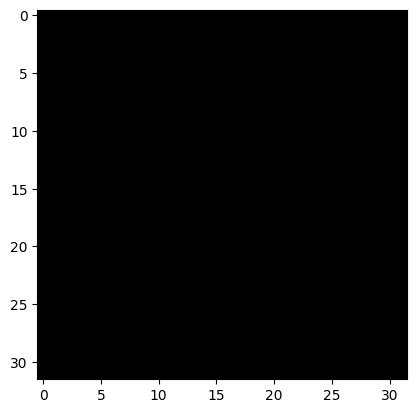

Label: 0.0


In [23]:
import random

train_dl = dataset_builder.get_train_loader()

# Display image and label.
train_features, train_labels = next(iter(train_dl))
example_boards = train_features[0]
example_curr = example_boards[0]
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
label = train_labels[0]
img = example_curr.squeeze()
count = len(img)
idx = random.randint(0, count-1)
channel = img[idx]
plt.imshow(channel, cmap="gray")
plt.show()
print(f"Label: {label}")

# Modeling


https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/

In [24]:
import torch.nn as nn
import torch.optim as optim


class CIFAR10Model(nn.Module):
    def __init__(self, 
                 channel_count, # adversary, self, hazard, food, etc
                 label_count = 10
                 ):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=channel_count,  
                               out_channels=32, # number of filters
                               kernel_size=(3,3), 
                               stride=1, 
                               padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(in_channels=32, 
                               out_channels=32, 
                               kernel_size=(3,3), 
                               stride=1, 
                               padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(8192, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(512, label_count)
 
    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.conv1(x)
        x = self.act1(x)
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x

In [25]:
# ex = ShapedExample(read_data[0])
# model = CIFAR10Model(channel_count=ex.channel_count(),
#                      label_count=1)
# loss_fn = nn.MSELoss() 
# # loss_fn = nn.CrossEntropyLoss() 
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [26]:
# import torch
# import torch.nn as nn

# input = torch.randn(3, 5, requires_grad=True)
# target = torch.randn(3, 5)

# hinge_loss = nn.HingeEmbeddingLoss()
# output = hinge_loss(input, target)
# output.backward()

# print('input: ', input)
# print('target: ', target)
# print('output: ', output)

In [27]:
# # Example of target with class indices
# loss = nn.CrossEntropyLoss()
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)
# output = loss(input, target)
# output.backward()
# output

In [28]:
# # Example of target with class probabilities
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.randn(3, 5).softmax(dim=1)
# output = loss(input, target)
# output.backward()
# output

# Training

In [72]:
class ModelTrainer():

    def __init__(self, dataset_builder, l1_scale, l2_scale):
        self.dataset_builder = dataset_builder
        self.l1_scale = l1_scale
        self.l2_scale = l2_scale

    def train_test(self, model, n_epochs=20, is_instant_only=True):
        for epoch in range(n_epochs):
            ### train
            for inputs, labels in self.get_train_loader(epoch):
                input_board_curr, input_boards_next = self.get_boards(inputs)
                ### forward, loss
                y_pred = model(input_board_curr)
                # account for optimal policy at next state
                if not is_instant_only:
                  labels += self.optimal_value_of_next_state(input_boards_next, model)
                loss = loss_fn(y_pred, labels)
                l1_reg_loss = 0
                l2_reg_loss = 0
                for param in model.parameters():
                  l1_reg_loss += torch.norm(param)
                  l2_reg_loss += torch.norm(param)
                loss += self.l1_scale * l1_reg_loss                   
                loss += self.l2_scale * l2_reg_loss                   
                ### backward, weight update
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            ### log progress
            self.regression_test(epoch, model)
            # self.classification_test(epoch, model)

    def optimal_value_of_next_state(self, input_boards_next, model):
        # tensor.detach().numpy()
        values = [model(board) for board in input_boards_next]
        values = [np.amax(inferred.detach().numpy()) for inferred in values]
        values = torch.Tensor(np.array(values)).type(torch.FloatTensor) 
        return values

    def get_boards(self, inputs):
        ### current vs next boards
        input_board_curr = inputs[0]
        input_boards_next = [input[1::] for input in inputs]
        return input_board_curr, input_boards_next

    def regression_test(self, epoch, model):
        acc = 0
        count = 0
        for inputs, labels in self.get_test_loader(epoch):
            input_board_curr, input_boards_next = self.get_boards(inputs)
            y_pred = model(input_board_curr)
            acc = abs(y_pred - labels).float().sum()
            count += len(labels)
        acc /= count
        print(f"Epoch {epoch}... error={acc}")

    def classification_test(self, epoch, model):
        acc = 0
        count = 0
        for inputs, labels in self.get_test_loader(epoch):
            input_board_curr, input_boards_next = self.get_boards(inputs)
            y_pred = model(input_board_curr)
            acc += (torch.argmax(y_pred, 1) == labels).float().sum()
            count += len(labels)
        acc /= count
        print(f"Epoch {epoch}... accuracy={acc}")

    def get_train_loader(self, epoch):
        if epoch == 0:
           return dataset_builder.get_train_loader()
        return dataset_builder.get_train_loader()

    def get_test_loader(self, epoch):
        if epoch == 0:
           return dataset_builder.get_test_loader()
        return dataset_builder.get_test_loader()


In [73]:
ex = ShapedExample(read_data[0])
model = CIFAR10Model(channel_count=ex.board_curr.channel_count(),
                     label_count=1)
loss_fn = nn.MSELoss() 
# loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.99) # lr=0.00001 0.0000000001

In [74]:
trainer = ModelTrainer(dataset_builder,
                       l1_scale = 1, l2_scale = 0.5)

trainer.train_test(model, n_epochs=5, is_instant_only=True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0... error=0.09289884567260742
Epoch 1... error=0.12030483037233353
Epoch 2... error=0.09071291238069534
Epoch 3... error=0.04318663477897644
Epoch 4... error=0.03843697905540466


In [75]:
trainer.train_test(model, n_epochs=5, is_instant_only=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0... error=0.03960588574409485
Epoch 1... error=0.05731692910194397
Epoch 2... error=0.014725753106176853
Epoch 3... error=0.056482892483472824
Epoch 4... error=0.04654152691364288


In [ ]:
# train_features, train_labels = next(iter(train_dl))

# model(train_features[0])

In [ ]:
# train_features, train_labels = next(iter(train_dl))

# single_example = train_features[0]
# single_board = [ single_example[0] ]
# loader = DataLoader(single_board, batch_size=1, shuffle=True)

# model(next(iter(loader)))

# # example = torch.Tensor()
# # example = train_features[0]
# # label = train_labels[0]
# # img = example.squeeze()

# # model(example)

In [ ]:
# next(iter(loader))

# Evaluate

# Save

In [76]:
torch.save(model.state_dict(), "/content/drive/MyDrive/snake-model-1.pth")

# Predict


In [100]:
class SnakeInference():

    def __init__(self):
        self.model = CIFAR10Model(channel_count=15,
                                  label_count=1)
        self.model.load_state_dict(torch.load('/content/drive/MyDrive/snake-model-1.pth'))
        self.model.eval()
        

    def value(self, example):
        shaped = ShapedExample(example)
        board = shaped.board_curr.get_board()
        input = torch.Tensor(np.array([board])).type(torch.FloatTensor)
        inferred = self.model(input)
        return inferred.detach().numpy()[0][0]

In [101]:
snaky = SnakeInference()

snaky.value(read_data[0])

-0.043658957